ASL, v.010323

# NLP using fastai & ULMFiT: a small case-study

This is an example of using [ULMFiT](https://arxiv.org/abs/1801.06146) from [fastai](https://docs.fast.ai/tutorial.text.html) for natural language processing (NLP).

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or on Kaggle, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
try:
    import colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
if (colab or kaggle):
    import sys
    # Install fastai etc
    !pip install -Uqq fastbook
    !{sys.executable} -m spacy download en_core_web_sm
    from fastbook import *
else:
    print("WARNING: To run this notebook locally you will have to install fastai")

We'll use the [spacy library]() for NLP and the [fastai]() library for deep learning.

In [3]:
import spacy

In [4]:
from fastai.text.all import *
from pprint import pprint as pp

# Load data

We use a data set collected in the work of Wakamiya et.al, _Tweet Classification Toward Twitter-Based Disease Surveillance: New Data, Methods, and Evaluations_, 2019: https://www.jmir.org/2019/2/e12783/

![medweb-paper](https://github.com/MMIV-ML/ELMED219-2022/raw/main/Lab2-NLP/assets/medweb-paper.png)

The data us supposed to represent tweets that discusses one or more of eight symptoms. 

Some examples from the original paper:<br><br>
<img src="https://github.com/MMIV-ML/ELMED219-2022/raw/main/Lab2-NLP/assets/medweb_examples.png">

We'll only look at the English language tweets:

In [5]:
#df = pd.read_csv('https://github.com/HVL-ML/DAT255/raw/main/3-NLP/data/medwebdata.csv')
df = pd.read_csv('data/medwebdata.csv')

In [6]:
df.head()

,ID,Tweet,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold,labels,is_test
0,1en,The cold makes my whole body weak.,0,0,0,0,0,0,0,1,Cold,False
1,2en,It's been a while since I've had allergy symptoms.,0,0,1,0,0,0,1,0,Hayfever;Runnynose,False
2,3en,I'm so feverish and out of it because of my allergies. I'm so sleepy.,0,0,1,0,0,1,1,0,Hayfever;Fever;Runnynose,False
3,4en,"I took some medicine for my runny nose, but it won't stop.",0,0,0,0,0,0,1,0,Runnynose,False
4,5en,I had a bad case of diarrhea when I traveled to Nepal.,0,0,0,0,0,0,0,0,sober,False


In [7]:
pp(df['Tweet'][10])

("They say we will have less pollen next spring, but it doesn't really matter "
 'to me, since my allergy gets severe in the autumn.')


From this text the goal is to determine whether the person is talking about one or more of the eight symptoms or conditions listed above:

In [8]:
list(df.columns[2:-2])

['Influenza',
 'Diarrhea',
 'Hayfever',
 'Cough',
 'Headache',
 'Fever',
 'Runnynose',
 'Cold']

# Prepare the data

As we know, for a computer, everything is numbers. We have to convert the text to a series of numbers, and then feed those to the computer. 

In the previous notebook, we saw how this can be done in two steps: **tokenization** and **numericalization**

## Tokenization

In tokenization the text is split into components, called tokens. 

Here are some result after the tokenization procedure used by ULMFiT:

In [9]:
data_lm = TextDataLoaders.from_df(df, text_col='Tweet', is_lm=True, valid_pct=0.1)

data_lm.show_batch(max_n=2)

,text,text_
0,"xxbos i saw news on the bird flu . xxmaj they said that xxunk , xxrep 3 xxunk xxunk and xxunk were xxunk . i think they managed a crisis very well . xxbos xxmaj now i have a headache on top of the stuffy nose , xxmaj i 'm staying home from school xxbos i bought a bento to go , but the xxunk is xxunk hot , it 's xxunk","i saw news on the bird flu . xxmaj they said that xxunk , xxrep 3 xxunk xxunk and xxunk were xxunk . i think they managed a crisis very well . xxbos xxmaj now i have a headache on top of the stuffy nose , xxmaj i 'm staying home from school xxbos i bought a bento to go , but the xxunk is xxunk hot , it 's xxunk ."
1,"a break . xxbos i xxunk the same thing xxunk times when talking to someone who is just not on the same xxunk as me , and they still did n't get it , i have such a headache . xxmaj it was like talking to an xxunk . xxbos i hear that if you cough too much , you can get bad chest and stomach xxunk . xxbos i have a","break . xxbos i xxunk the same thing xxunk times when talking to someone who is just not on the same xxunk as me , and they still did n't get it , i have such a headache . xxmaj it was like talking to an xxunk . xxbos i hear that if you cough too much , you can get bad chest and stomach xxunk . xxbos i have a xxunk"


Tokens starting with "xx" are special. `xxbos` means the beginning of the text, `xxmaj` means that the following word is capitalized, `xxup` means that the following word is in all caps, and so on.

The tokens `xxunk` replaces words that are rare in the text corpus. We keep only words that appear at least twice (with a set maximum number of different words, 60.000 in our case). This is called our **vocabulary**.

## Numericalization

We convert tokens to numbers by making a list of all the tokens that have been used and assign them to numbers.

The above text is replaced by numbers, as in this example

In [10]:
data_lm.train_ds[0][0]

TensorText([  2,   8,   0,   9, 498,  15,  13,   0, 351,  81,  11, 428,  39,
             11,  32,  10])

> **We are now in a position where the computer can compute on the text.**

# "Classical" versus deep learning-based NLP

In [15]:
try: 
    nlp = spacy.load("en_core_web_sm")
    print("Spacy model loaded")
except:
    import sys
    !{sys.executable} -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

Spacy model loaded


### Sentence Boundary Detection: splitting into sentences

Example sentence:
> _"Patient presents for initial evaluation of cough. Cough is reported to have developed acutely and has been present for 4 days. Symptom severity is moderate. Will return next week."_

In [16]:
sentence = "Patient presents for initial evaluation of cough. Cough is reported to have developed acutely and has been present for 4 days. Symptom severity is moderate. Will return next week."
doc = nlp(sentence)
 
for sent in doc.sents:
    print(sent)

Patient presents for initial evaluation of cough.
Cough is reported to have developed acutely and has been present for 4 days.
Symptom severity is moderate.
Will return next week.


### Named Entity Recognition

In [17]:
for ent in doc.ents:
    print(ent.text, ent.label_)

4 days DATE
next week DATE


In [18]:
from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

### Dependency parsing

In [19]:
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

> There's a lot more to natural language processing, of course! Have a look at [spaCy 101: Everything you need to know](https://spacy.io/usage/spacy-101) for some examples.

In general, data preparation and feature engineering is a huge and challenging undertaking when using machine learning to analyze text. 

However, in what's called _deep learning_ most of this work is done by the computer! That's because deep learning does feature extraction _and_ prediction in the same model. 

This results in much less work and, often, _in much better models_!

![MLvsDL](https://aylien.com/images/uploads/general/tumblr_inline_oabas5sThb1sleek4_540.png)

# Deep learning language model

We now come to a relatively new and very powerful idea for deep learning and NLP. An idea that created a small revolution in NLP a couple of years ago ([1](https://blog.openai.com/language-unsupervised/), [2](http://ruder.io/nlp-imagenet/))

We want to create a system that can classify text into one or more categories. This is a complex problem as the computer must somehow implicitly learn to "read." 

Idea: why not _first_ teach the computer to "read" and _then_ let it loose on the classification task?

We can teach the computer to "understand" language by training it to guess the next word of a sentence, using as much training data as we can get hold of. This is called ***language modelling*** in NLP. 

Guessing the next word is a difficult task: our own ability to do this is based on our knowledge of the language and about the world.

> What word fits here? _"The light turned green, and Per crossed the ___"_

Luckily, obtaining large amounts of training data for language models is simple: any text can be used. The labels are simply the next word of a subpart of the text. 

We can, for example, use Wikipedia. Then, after the model performs alright at predicting the next word of Wikipedia text, we can fine-tune it on text that's closer to the classification task we're after. 

> This is often called ***transfer learning***.

We can use the tweet text to fine-tune a model that's already been pretrained on Wikipedia:

In [20]:
data_lm = TextDataLoaders.from_df(df, text_col='Tweet', is_lm=True, valid_pct=0.1)

data_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj looks like the flu is spreading in xxmaj china . xxbos xxmaj anybody , any xxunk for how to xxunk with a headache ? "" xxbos xxmaj my daughter has a fever , so xxmaj i 'm going home early . xxbos xxmaj by the way , how 's your headache now , me ? xxbos i wonder if this really works for allergies . xxbos i have a light","xxmaj looks like the flu is spreading in xxmaj china . xxbos xxmaj anybody , any xxunk for how to xxunk with a headache ? "" xxbos xxmaj my daughter has a fever , so xxmaj i 'm going home early . xxbos xxmaj by the way , how 's your headache now , me ? xxbos i wonder if this really works for allergies . xxbos i have a light headache"
1,"xxmaj i 'm recovering from it . i need to xxunk a lot of water . xxbos i wonder if you can catch the flu just from xxunk hands ? xxbos xxmaj allergies are so exhausting . xxmaj i 'm blowing my nose so much it hurts . xxmaj are n't the xxunk xxunk from xxmaj china coming , too ? xxbos xxmaj there was a xxmaj tokyo scene in the xxmaj","i 'm recovering from it . i need to xxunk a lot of water . xxbos i wonder if you can catch the flu just from xxunk hands ? xxbos xxmaj allergies are so exhausting . xxmaj i 'm blowing my nose so much it hurts . xxmaj are n't the xxunk xxunk from xxmaj china coming , too ? xxbos xxmaj there was a xxmaj tokyo scene in the xxmaj xxunk"
2,"xxmaj i 'm going on this xxunk . xxbos xxmaj the throat pain has xxunk , but i still get phlegm . xxbos xxmaj i 'm so feverish and out of it because of my allergies . xxmaj i 'm so sleepy . xxbos i have n't had the mumps . xxmaj is it that bad ? xxbos i ca n't focus on my work , because of diarrhea . xxbos xxmaj","i 'm going on this xxunk . xxbos xxmaj the throat pain has xxunk , but i still get phlegm . xxbos xxmaj i 'm so feverish and out of it because of my allergies . xxmaj i 'm so sleepy . xxbos i have n't had the mumps . xxmaj is it that bad ? xxbos i ca n't focus on my work , because of diarrhea . xxbos xxmaj my"


In [21]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.3,
                               metrics=[accuracy, Perplexity()], wd=0.1, model_dir='.').to_fp16()

Let's start training:

In [22]:
learn.fit_one_cycle(1, 5e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.829901,4.604457,0.241848,99.928696,00:03


In [23]:
learn.unfreeze()
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.649045,2.984439,0.377038,19.775398,00:01
1,3.108405,2.635219,0.413949,13.946364,00:01
2,2.773164,2.602164,0.418025,13.492908,00:01


...and save the parts of the model that we can reuse for classification later:

In [24]:
learn.save_encoder('medweb_finetuned')

## Test the language model

We can test the language model by having it guess the next given number of words on a starting text:

In [25]:
def make_text(seed_text, nb_words):
    """
    Use the trained language model to produce text. 
    Input:
        seed_text: some text to get the model started
        nb_words: number of words to produce
    """
    pred = learn.predict(seed_text, nb_words, temperature=0.75)
    pp(pred)

In [26]:
make_text("I'm not feeling too good as my", 10)

"I 'm not feeling too good as my wife , and now i have a fever ."


In [27]:
make_text("No, that's a", 40)

("No , that 's a good deal for a cold . My wife got the flu . She woke up with "
 "a headache . i was so thirsty . i think I 'm gon na go to work .")


Now we have something that seems to produce text that resembles the text to be classified. 

> **Note:** It's interesting to see that the model can come up with text that makes some sense (mostly thanks to training on Wikipedia), and that the text resembles the medical tweets (thanks to the fine-tuning). 

> **Note** also that an accuracy of 30-40% when predicting the next word of a sentence is pretty impressive, as the number of possibilities is very large (equal to the size of the vocabulary).

> **Also note** that this is not the task we care about: it's a pretext task before the tweet classification. 

# Classifier

In [28]:
medweb = DataBlock(blocks=(TextBlock.from_df(text_cols='Tweet', seq_len=12, vocab=data_lm.vocab), MultiCategoryBlock), 
                  get_x = ColReader(cols='text'), 
                  get_y = ColReader(cols='labels', label_delim=";"),
                  splitter = ColSplitter(col='is_test'))

data = medweb.dataloaders(df, bs=8)

Now our task is to predict the possible classes the tweets can be assigned to:

In [29]:
data.show_batch()

,text,None
0,"xxbos i heard that in xxmaj china , someone died of a new type of flu xxunk from the bird flu . xxmaj that got me wondering if there is any xxunk like some xxunk to check to see if i have the flu or not . xxmaj they talk about the flu a lot on xxup tv , but i have no idea how they xxunk the outbreak .",sober
1,"xxbos xxmaj my stuffy nose is finally gone , so i went for a xxmaj tokyo xxunk . xxmaj it 's great how you can see the xxunk you love while out on a walk . xxmaj like pretty xxunk , or a xxunk talking with their child .",sober
2,"xxbos xxmaj when it gets hot out , we xxunk out cool xxunk and xxunk to xxunk with the a / xxup xxunk , but it 's actually bad because the cold air xxunk can make you sick and end up with a fever .",Fever
3,"xxbos xxmaj my wife is blowing her nose constantly because of allergies , but she has a slight fever , too , so i xxunk that it could be a cold , but she said definitely not . xxmaj she always xxunk things out .",Cold;Fever;Hayfever;Runnynose
4,"xxbos xxmaj there are so many medicines thanks to scientific developments , but they say that because there are so many xxunk of cold xxunk , there 's been little xxunk in the xxunk and xxunk of xxunk medicines for xxunk virus .",sober
5,"xxbos i went to the xxup xxunk and was diagnosed with xxunk . xxmaj that makes me wonder if a runny nose is because of xxunk ? i have no idea , but i got a tremendous xxunk of medicine .",Cold;Runnynose
6,"xxbos i do n't know if it 's the cold , but xxmaj i 've had a stomachache since this morning . i might have diarrhea as well , but my job xxunk me to be on my xxunk .",Diarrhea
7,"xxbos xxmaj so sleepy , so sleepy , so sleepy , so sleepy , so sleepy , so sleepy , so sleepy , so sleepy , xxmaj i 'm xxunk calling in sick , saying i have a cold .",sober


In [33]:
learn_clf = text_classifier_learner(data, AWD_LSTM, seq_len=16, pretrained=True, 
                                    drop_mult=0.6, 
                                    metrics=[accuracy_multi, 
                                             F1ScoreMulti(average='micro'),
                                             F1ScoreMulti(average='macro'),
                                             PrecisionMulti(average='micro'),
                                             PrecisionMulti(average='macro'),
                                             RecallMulti(average='micro'),
                                             RecallMulti(average='macro'),
                                             HammingLossMulti(),
                                             ], 
                                    model_dir='.').to_fp16()

In [34]:
learn_clf = learn_clf.load_encoder('medweb_finetuned')

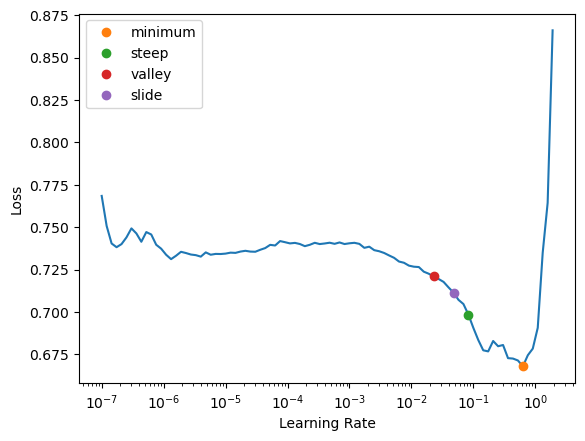

In [35]:
lr = learn_clf.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [37]:
base_lr = (lr.valley + lr.steep)/2
print(base_lr)

0.05304252542555332


In [38]:
learn_clf.fine_tune(8, base_lr=base_lr)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,precision_score,precision_score,recall_score,recall_score,hamming_loss,time
0,0.226184,0.172740,0.931076,0.740353,0.748089,0.767978,0.761826,0.714646,0.781508,0.068924,00:08
1,0.185326,0.141058,0.946701,0.799477,0.810489,0.828146,0.823915,0.772727,0.807211,0.053299,00:07
2,0.182906,0.151628,0.948090,0.804958,0.807338,0.832659,0.820044,0.779040,0.803152,0.051910,00:07
3,0.178776,0.160660,0.942882,0.788424,0.799063,0.803408,0.800351,0.773990,0.832514,0.057118,00:07
4,0.141903,0.169771,0.939931,0.770252,0.764393,0.812325,0.840799,0.732323,0.714871,0.060069,00:08
5,0.131871,0.152090,0.947569,0.813810,0.811301,0.795181,0.780218,0.833333,0.858336,0.052431,00:08
6,0.103984,0.146367,0.953125,0.831039,0.832125,0.823821,0.813803,0.838384,0.857989,0.046875,00:08
7,0.094351,0.145895,0.955555,0.837357,0.836610,0.842711,0.820604,0.832071,0.862983,0.044444,00:08
8,0.061942,0.153659,0.959375,0.850575,0.848415,0.860465,0.842761,0.840909,0.860130,0.040625,00:08
9,0.053362,0.159975,0.959028,0.850633,0.847346,0.852792,0.835052,0.848485,0.864673,0.040972,00:08


## Is it a good classifier?

We can test it out on some example text:

In [39]:
learn_clf.predict("I'm feeling really bad. My head hurts. My nose is runny. I've felt like this for days.")

((#2) ['Headache','Runnynose'],
 tensor([False, False, False, False, False,  True, False,  True, False]),
 tensor([1.7510e-02, 1.5731e-03, 1.1235e-04, 2.5410e-03, 4.8030e-04, 9.9521e-01,
         8.8881e-05, 9.2710e-01, 6.9038e-03]))

It seems to produce reasonable results. _But remember that this is a small data set._ One cannot expect great things when asking the model to make predictions on text outside the small material it has been trained on. 

Go ahead and try to have the model predict symptoms for a few example sentences, and you'll see.

### How does it compare to other approaches?

From the [original article](https://www.jmir.org/2019/2/e12783/) from 2019 that presented the data set:

<img src="https://github.com/MMIV-ML/ELMED219-2022/raw/main/Lab2-NLP/assets/medweb_results.png">

The "NAIST-en" models are _"ensembles of hierarchical attention network and deep character-level convolutional neural network with loss functions (negative loss function, hinge, and hinge squared)"_. I.e. also deep learning-based models.